In [1]:
import numpy as np
import scipy
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

### Advanced Statistical Methods Project

Dmitry Salnikov, 2018

### Data Generation

Following chapter 6 we consider estimation of linear functional i.e. 
$$\int_{0}^{1}f(x) dx$$

given set $\{ \psi_i \}_{i=1}^p$ of piecewise-constant basis functions $\psi_i = c_iI[a_i, b_i)$

The true function is defined as:
$$
\sum_{i=0}^{dim} {\theta_i \psi_{i}}
$$
In experiments we take $dim = 20$, function boundaries $a_i, b_i, c_i, \theta_i$ are $U[0, 1]$ independent random variables 

Given n data points $\{ x_i \}_{i=1}^{n}$ the design matrix $\Psi$ is as usual defined as $p \times n$ matrix ${\psi_j(x_i)}$

Data is split 0.8 / 0.2 on train/validation

In [2]:
def piecewise_const_function(c, x, y):
    assert(x <= y)
    def function(point):
        if point >= x and point < y:
            return c
        else:
            return 0
    return np.vectorize(function)

In [3]:
def true_function_1():
    coef = np.random.rand(20, 4)
    combination = []
    for i in range(20):
        if coef[i][0] > coef[i][1]:
            coef[i][0], coef[i][1] = coef[i][1], coef[i][0]
        combination.append(piecewise_const_function(coef[i][2], coef[i][0], coef[i][1]))
    def function(x):
        s = 0
        for i in range(20):
            #print(coef[i][3] * combination[i](x))
            s += coef[i][3] * combination[i](x)
        return s
    true_theta = coef[:, 3]
    return np.vectorize(function), true_theta 

In [4]:
func1 = piecewise_const_function(1, 0, 0.5)

In [5]:
N_POINTS = 500
beta = 1
X = 2
x = np.linspace(0, 1, num=N_POINTS)

In [6]:
def generate_basis(start, end, value=1):
    basis_functions = []
    for i in range(10):
        interval_size = (end - start) / 2**i
        for j in range(2**i - 1):
            func = piecewise_const_function(value, j * interval_size, (j + 1) * interval_size)
            basis_functions.append(func)
    return basis_functions

def generate_w(start, end, value = 1):
    w = []
    for i in range(10):
        interval_size = (end - start) / 2**i
        for j in range(2**i - 1):
            w.append(interval_size)
    return np.array(w)

def generate_noize(x):
    dimensions = x.shape[0]
    return np.random.multivariate_normal(0 * np.ones(dimensions), 0.01 * np.eye(dimensions))

def generate_psi(x):
    PSI_arr = []
    for basis_function in generate_basis(0, 1):
        PSI_arr.append(basis_function(x).astype(np.float64))

    PSI = np.vstack(PSI_arr)
    return PSI

def emperical_risk(theta_true, theta_pred, W = None):
    if W is None:
        W = np.eye(theta_true.shape[0])
    diff = W @ (theta_true - theta_pred)
    return np.mean(diff**2)

def PSI_projection(psi_matrix, dim):
    truncated_matrix = np.copy(psi_matrix)
    truncated_matrix[dim + 1:, :] = 0
    return truncated_matrix

In [7]:
true_function, true_theta = true_function_1()

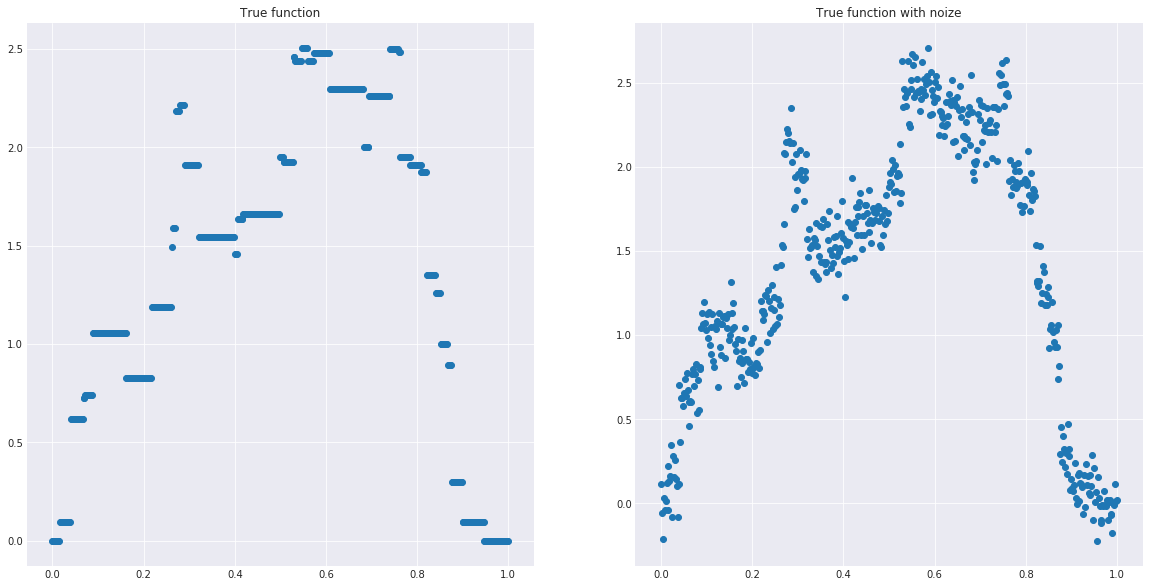

In [8]:
with sns.axes_style('darkgrid'):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax1.scatter(x, true_function(x))
    ax1.set_title('True function')
    ax2.scatter(x, true_function(x) + generate_noize(x))
    ax2.set_title('True function with noize')
    plt.show()

In [9]:
from sklearn.cross_validation import train_test_split

/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
y = generate_noize(x) + true_function(x)
X_train, X_holdout, y_train, y_holdout = train_test_split(x, y)

In [11]:
PSI = generate_psi(X_train)

theta = (np.linalg.pinv(PSI @ PSI.T) @ PSI ) @ y_train

prediction = generate_psi(X_holdout).T @ theta

W = generate_w(0, 1)

true_theta_bigdim = np.zeros_like(theta)
true_theta_bigdim[:len(true_theta)] = true_theta

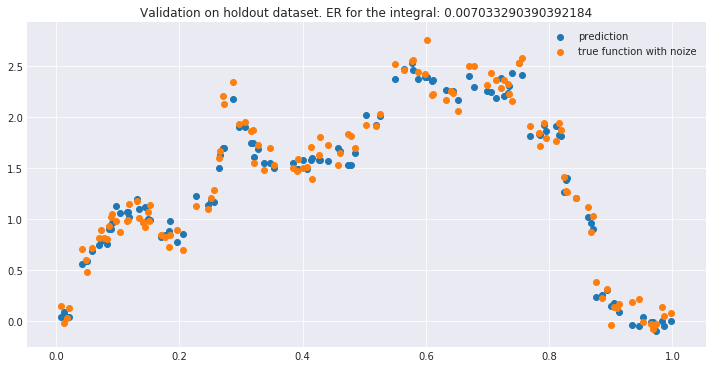

In [12]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(10, 5))
    plt.scatter(X_holdout, prediction, label='prediction')
    plt.scatter(X_holdout, y_holdout, label='true function with noize')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.title('Validation on holdout dataset. ER for the integral: {}'.format(emperical_risk(true_theta_bigdim, theta, W)))
    plt.show()

In [ ]:
PSI_lowerd = generate_psi(X_train)
PSI_lowerd = PSI_projection(PSI, dim=500)

PSI_H = PSI_projection(generate_psi(X_holdout), dim=500)


theta = (np.linalg.pinv(PSI_lowerd @ PSI_lowerd.T) @ PSI_lowerd ) @ y_train

prediction = PSI_H.T  @ theta

W = generate_w(0, 1)

true_theta_bigdim = np.zeros_like(theta)
true_theta_bigdim[:len(true_theta)] = true_theta

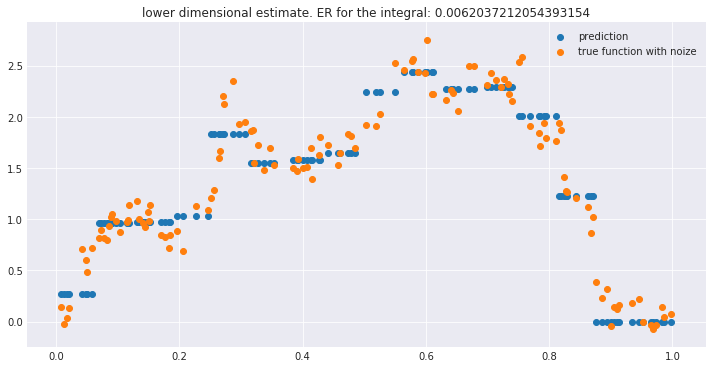

In [27]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(10, 5))
    plt.scatter(X_holdout, prediction, label='prediction')
    plt.scatter(X_holdout, y_holdout, label='true function with noize')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.title('lower dimensional estimate. ER for the integral: {}'.format(emperical_risk(true_theta_bigdim, theta, W)))
    plt.show()

We can see that the ER is lower if we consider lower dimensions

### Weighting matrix


$$
\int_{0}^{1} c I[a, b) dx= c\int_{0}^{1} I[a, b)dx = c\int_{\max(0, a)}^{min(1, b)}dx = c(\min(1, b) - \max(0, a))
$$ 

Sice we consider our function on the $[0, 1]$ interval, we can just say that $W_i = b_i - a_i$

So, in case of integral estimation matrix $K_m = WS_m = W(\Psi \Psi^\top)^{-1} \Psi$

In [14]:
#generate matrices for different dimensions
from tqdm import tqdm_notebook
psi_matrices = []
thetas = []
for i in tqdm_notebook(range(1, 200)):
    psi_ld = PSI_projection(PSI, dim=i)
    theta_ld = (np.linalg.pinv(psi_ld @ psi_ld.T) @ psi_ld)
    psi_matrices.append(psi_ld)
    thetas.append(theta_ld)

In [15]:
erm_values = []
for theta_matrix in tqdm_notebook(thetas):
    holdout_psi = generate_psi(X_holdout)
    theta = theta_matrix @ y_train
    true_theta_bigdim = np.zeros_like(theta)
    true_theta_bigdim[:len(true_theta)] = true_theta
    erm_values.append(emperical_risk(true_theta_bigdim, theta, W))
erm_values = np.array(erm_values)

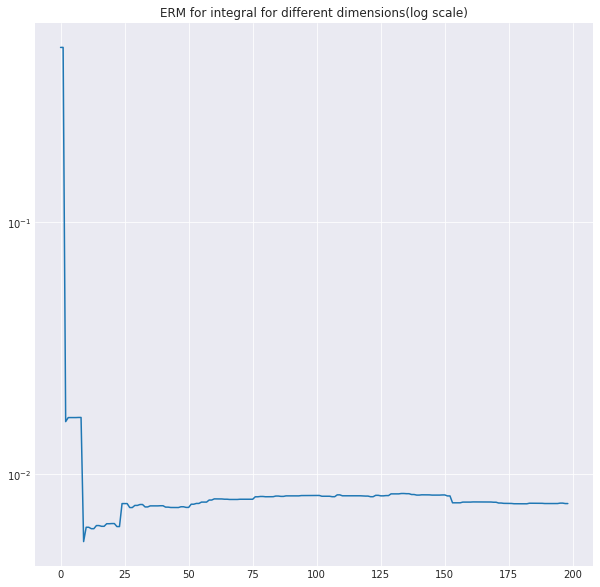

In [54]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(10, 10))
    plt.plot(erm_values)
    plt.yscale('log')
    plt.title('ERM for integral for different dimensions(log scale)')

### Oracle choice 

$$
m^* = \min_{m^o} \{\max_{m \in M^+(m^o)}{\| b_{m, m^o} \|^2} - \beta^2 p_{m, m^o} \le 0 \}
$$

where we estimate $\| b_{m, m^o} \| = \| \phi_m^* - \phi^* \| = \|K_{m, m^o}Y \|$ 

and $p_{m, m^o} = \sigma^2 tr(K_{m, m^o} K_{m, m^o}^\top)$

In [29]:
def oracle_estimate(beta):
    ms = []
    max_val_is = []
    for i in tqdm_notebook(range(199)):
        max_val_i = -np.inf
        for j in range(i, 199):
            if i == j:
                continue
            k_mm = (psi_matrices[i].T @ thetas[i]) - (psi_matrices[j].T @ thetas[j])
            b_mm = np.linalg.norm(k_mm @ y_train)
            p_mm = np.trace(k_mm @ k_mm.T)
            val = b_mm**2 - beta**2 * p_mm
            if val > max_val_i:
                max_val_i = val
        #print(max_val_i)
        if max_val_i <= 0:
            ms.append(i)
            max_val_is.append(max_val_i)
    return ms, max_val_is

In [31]:
beta_dep = []
for beta_value in tqdm_notebook(np.linspace(1, 10, num=10)):
    ms, max_val_is = oracle_estimate(beta_value)
    beta_dep.append(np.min(ms))

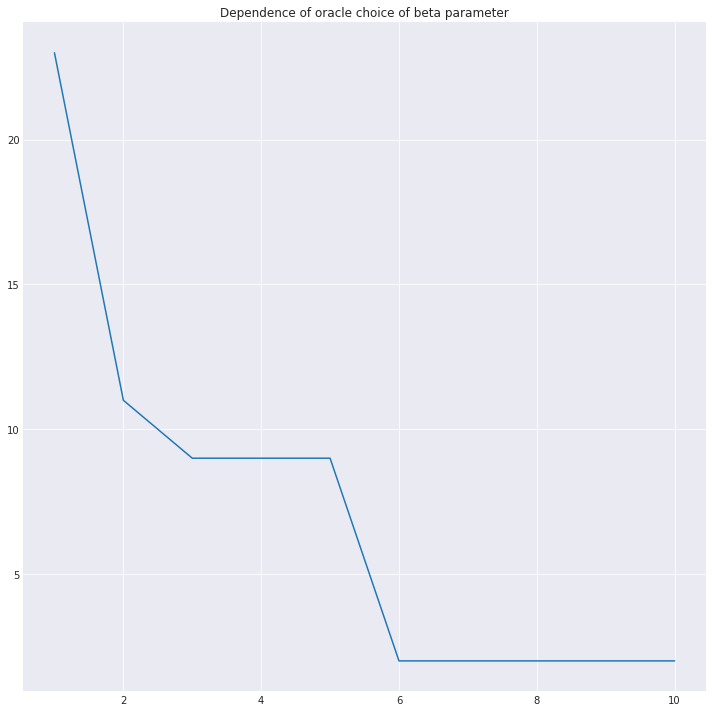

In [34]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(10, 10))
    plt.title('Dependence of oracle choice of beta')
    plt.plot(np.linspace(1, 10, num=10), beta_dep)
    plt.tight_layout()
    plt.show()

### Oracle estimation is pretty close to the original parameter number

In [23]:
print('Oracle choice: {}'.format(np.min(ms)))

Oracle choice: 23


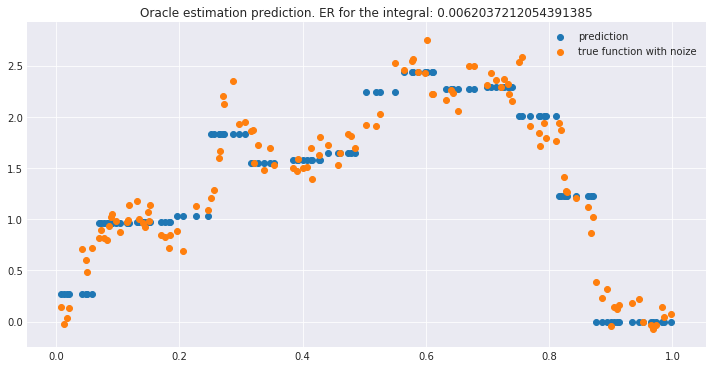

In [69]:
PSI_lowerd = generate_psi(X_train)
PSI_lowerd = PSI_projection(PSI, dim=23)

PSI_H = PSI_projection(generate_psi(X_holdout), dim=23)


theta = (np.linalg.pinv(PSI_lowerd @ PSI_lowerd.T) @ PSI_lowerd ) @ y_train

prediction = PSI_H.T  @ theta

W = generate_w(0, 1)

true_theta_bigdim = np.zeros_like(theta)
true_theta_bigdim[:len(true_theta)] = true_theta

with sns.axes_style('darkgrid'):
    plt.figure(figsize=(10, 5))
    plt.scatter(X_holdout, prediction, label='prediction')
    plt.scatter(X_holdout, y_holdout, label='true function with noize')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.title('Oracle estimation prediction. ER for the integral: {}'.format(emperical_risk(true_theta_bigdim, theta, W)))
    plt.show()

### Adaptive choice

$$\hat{m} = \min_{m^o} \{ {\max_{m \in M^+(m^o)}} \{ {T_{m, m^o} - \xi_{m, m^o}} \} \le 0 \}$$

where
$T_{m, m^o} = \| K_{m, m^o} Y \|, \xi = z_{m, m^o}(x + q)$


$z_{m, m^o}$ is defined as
$$
P(\| \xi_{m, m^o} \| \ge z_{m, m^o}(x)) \le \exp(x)
$$

We consider the upper bound of $\xi = \sigma(1 + \beta)\sqrt{m - m^o} + \sqrt{(2x + 2 \log( M)}$ which lower bounds the quantity $T_{m, m^o} - \xi_{m, m^o}$

In [58]:
def adaptive_estimate(x, beta):
    ms_adaptive = []
    max_val_is_adaptive = []
    for i in tqdm_notebook(range(199)):
        max_val_i = -np.inf
        for j in range(i + 1, 199):
            k_mm = (psi_matrices[i].T @ thetas[i]) - (psi_matrices[j].T @ thetas[j])
            T_mm = np.linalg.norm(k_mm @ y_train)
            p_mm = np.trace(k_mm @ k_mm.T)        
            xi_mm = (1 + beta)*np.sqrt(j - i) + np.sqrt(2*x + 2*np.log(i + 1))
            val = T_mm - xi_mm 
            if val > max_val_i:
                max_val_i = val
#         print(max_val_i)
        if max_val_i <= 0:
            ms_adaptive.append(i)
            max_val_is_adaptive.append(max_val_i)
    return ms_adaptive, max_val_is_adaptive

In [67]:
beta_dep_adaptive = []
for beta_value in tqdm_notebook(np.linspace(1, 10, num=10)):
    ms_adaptive, max_val_is_adaptive = adaptive_estimate(2, beta_value)
    beta_dep_adaptive.append(np.min(ms_adaptive))

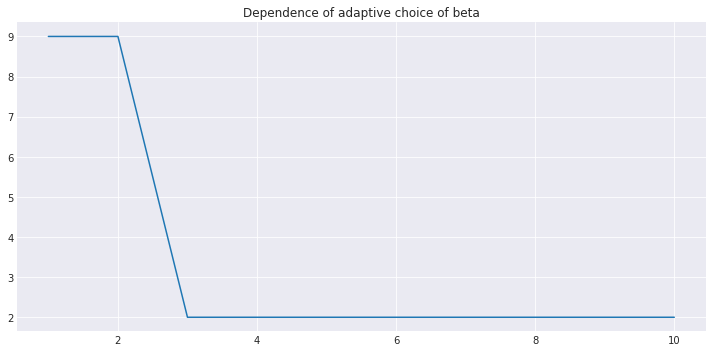

Adaptive choice: 9


In [72]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(10, 5))
    plt.title('Dependence of adaptive choice of beta')
    plt.plot(np.linspace(1, 10, num=10), beta_dep_adaptive)
    plt.tight_layout()
    plt.show()

print('Adaptive choice: {}'.format(np.min(beta_dep_adaptive[0])))

In [83]:
PSI_lowerd = generate_psi(X_train)
PSI_lowerd_1 = PSI_projection(PSI, dim=23)

PSI_H_1 = PSI_projection(generate_psi(X_holdout), dim=23)
theta_1 = (np.linalg.pinv(PSI_lowerd_1 @ PSI_lowerd_1.T) @ PSI_lowerd_1) @ y_train

prediction_1 = PSI_H_1.T  @ theta_1

PSI_lowerd_2 = PSI_projection(PSI, dim=9)
PSI_H_2 = PSI_projection(generate_psi(X_holdout), dim=9)
theta_2 = (np.linalg.pinv(PSI_lowerd_2 @ PSI_lowerd_2.T) @ PSI_lowerd_2 ) @ y_train
prediction_2 = PSI_H_2.T  @ theta_2


W = generate_w(0, 1)

true_theta_bigdim = np.zeros_like(theta)
true_theta_bigdim[:len(true_theta)] = true_theta

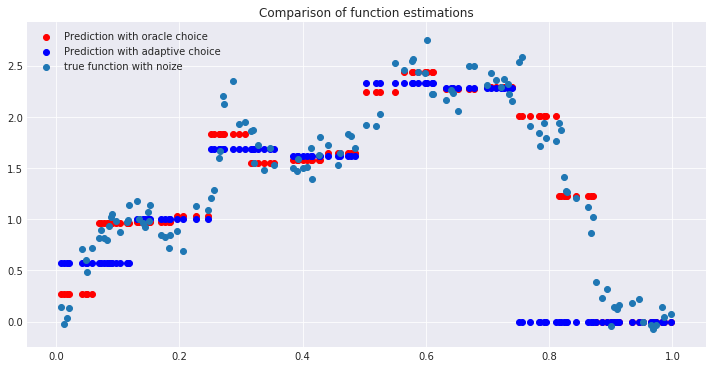

Emperical risk with oracle choice 0.0062037212054391385
Emperical risk for adaptive choice 0.016818260637090306


In [84]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(10, 5))
    plt.scatter(X_holdout, prediction_1, label='Prediction with oracle choice', color='red')
    plt.scatter(X_holdout, prediction_2, label='Prediction with adaptive choice', color='blue')
    plt.scatter(X_holdout, y_holdout, label='true function with noize')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.title('Comparison of function estimations')
    plt.show()

print('Emperical risk with oracle choice {}'.format(emperical_risk(true_theta_bigdim, theta_1, W)))
print('Emperical risk for adaptive choice {}'.format(emperical_risk(true_theta_bigdim, theta_2, W)))